In [1]:
import desitarget.io
import desitarget.mtl
import desimodel.io
import fitsio
import sys
import os
from astropy.table import Table,vstack,unique,join
import numpy as np
import desisim.quickcat
import glob
from matplotlib import pyplot as plt

In [14]:
l = Table.read('/global/cscratch1/sd/adamyers/testmtl/outexample/main/secondary/dark/mtl-dark-hp-2298.ecsv')

In [15]:
np.unique(l['TIMESTAMP'],return_counts=True)

(<Column name='TIMESTAMP' dtype='str25' unit='s' length=4>
 2021-05-13T08:15:37+00:00
 2021-06-23T15:25:24+00:00
 2021-08-24T23:19:30+00:00
 2021-08-24T23:19:44+00:00,
 array([704,  66,   1,  67]))

In [10]:
sel = l['TIMESTAMP'] == '2021-08-24T23:19:46+00:00'
tids = l[sel]['TARGETID']
i = 0
for tid in tids:
    sel = l['TARGETID'] == tid
    print(l[sel]['TARGET_STATE'])
    i += 1
    if i > 10:
        break
        


 TARGET_STATE 
--------------
     LRG|UNOBS
LRG|MORE_ZGOOD
      LRG|DONE
   TARGET_STATE   
------------------
     ELG_LOP|UNOBS
ELG_LOP|MORE_ZGOOD
      ELG_LOP|DONE
 TARGET_STATE 
--------------
     LRG|UNOBS
LRG|MORE_ZGOOD
      LRG|DONE
  TARGET_STATE  
----------------
       QSO|UNOBS
QSO|MORE_MIDZQSO
        QSO|DONE
  TARGET_STATE  
----------------
       QSO|UNOBS
QSO|MORE_MIDZQSO
    ELG_LOP|DONE
 TARGET_STATE 
--------------
     LRG|UNOBS
LRG|MORE_ZGOOD
      LRG|DONE
   TARGET_STATE   
------------------
     ELG_LOP|UNOBS
ELG_LOP|MORE_ZGOOD
      ELG_LOP|DONE
  TARGET_STATE  
----------------
       QSO|UNOBS
QSO|MORE_MIDZQSO
        QSO|DONE
 TARGET_STATE 
--------------
     QSO|UNOBS
QSO|MORE_ZGOOD
QSO|MORE_ZGOOD
   TARGET_STATE   
------------------
     ELG_LOP|UNOBS
ELG_LOP|MORE_ZGOOD
      ELG_LOP|DONE
   TARGET_STATE   
------------------
     ELG_HIP|UNOBS
ELG_LOP|MORE_ZWARN
      ELG_LOP|DONE


In [24]:
sel = l['TARGETID'] == 39632981408614565
print(l[sel]['PRIORITY'])

PRIORITY
--------
    3400
     100
    1918
       2
    1918


In [21]:
fil='/global/cscratch1/sd/adamyers/testmtl/QSO_reobs_jinyi.fits'
f = fitsio.FITS(fil)

In [23]:
f[1]


  file: /global/cscratch1/sd/adamyers/testmtl/QSO_reobs_jinyi.fits
  extension: 1
  type: BINARY_TBL
  extname: Joined
  rows: 9
  column info:
    RA                  f8  
    DEC                 f8  
    TARGETID            i8  
    VI_z                f8  
    VI_check            S9  
    pipeline_z          f8  
    Note               S29  

In [44]:
runs = [0,1,2,3]
ldir = os.environ['CSCRATCH']+'/testledgers/dr9/0.50.0.dev4501/mtl/main/dark/'

In [14]:
if not os.path.exists(os.environ['CSCRATCH']+'/testledgers/fiberassign'):
    os.mkdir(os.environ['CSCRATCH']+'/testledgers/fiberassign')

In [86]:
for run in runs:
    tileff = '/global/cfs/cdirs/desi/datachallenge/onepercent/catalogs/dark/e2etiles_run'+str(run)+'.fits'
    tilef = fitsio.read(tileff)
    #tilef = desimodel.io.load_tiles(tilesfile='/global/cfs/cdirs/desi/datachallenge/onepercent/catalogs/dark/e2etiles_run0.fits') #not sure why this doesn't work
    tars = desitarget.io.read_targets_in_tiles(ldir, tiles=tilef, mtl=True, unique=True)
    print('found '+str(len(tars))+' targets')
    tarf = os.environ['CSCRATCH']+'/testledgers/darktar'+str(run)+'.fits'
    fitsio.write(tarf,tars,clobber=True)
    skies = desitarget.io.read_targets_in_tiles('/global/cfs/cdirs/desi/target/catalogs/dr9/0.49.0/skies',tiles=tilef)
    skyf = os.environ['CSCRATCH']+'/testledgers/skies.fits'
    fitsio.write(skyf,skies)
    fapath = os.environ['CSCRATCH']+'/testledgers/fiberassign/'+str(run)
    if not os.path.exists(fapath):
        os.mkdir(fapath)    
    fba_run = 'fba_run --targets {} --sky {} --footprint {}  --dir {} --rundate 2020-01-01T00:00:00 --overwrite'.format(
                tarf, skyf, tileff, fapath)
    print(fba_run)
    os.system(fba_run)   
    tars = Table.read(tarf)
    #truth info for zcat, actual values don't matter for this test
    tars['TRUEZ'] = np.random.random(len(tars))*3
    tars['TRUETYPE'] = 'GALAXY'
    tars['TRUESPECTYPE'] = 'GALAXY'
    fba_files = np.sort(glob.glob(os.path.join(fapath,"fba-*.fits")))
    if run == 0:
        zcat = desisim.quickcat.quickcat(fba_files, tars, tars, fassignhdu='FASSIGN', perfect=True)
    else:  
        old_zcat = Table.read(old_zcat_filename)
        zcat = desisim.quickcat.quickcat(fba_files, tars, tars, fassignhdu='FASSIGN', zcat=old_zcat, perfect=True)
    old_zcat_filename = os.environ['CSCRATCH']+'/testledgers/zcat'+str(run)+'.fits'
    zcat.write(old_zcat_filename, overwrite=True)
    desitarget.mtl.update_ledger(ldir, tars, zcat)
    print('run '+str(run)+' done')
    print('the zcat contains this many entries: '+str(len(zcat)))

found 678179 targets
fba_run --targets /global/cscratch1/sd/ajross/testledgers/darktar0.fits --sky /global/cscratch1/sd/ajross/testledgers/skies.fits --footprint /global/cfs/cdirs/desi/datachallenge/onepercent/catalogs/dark/e2etiles_run0.fits  --dir /global/cscratch1/sd/ajross/testledgers/fiberassign/0 --rundate 2020-01-01T00:00:00 --overwrite
INFO:quickcat.py:592:quickcat: Tue Feb 23 14:07:04 2021 QC Reading 39 tiles
INFO:quickcat.py:636:quickcat: Tue Feb 23 14:07:05 2021 QC Trimming truth to just observed targets
INFO:quickcat.py:643:quickcat: Tue Feb 23 14:07:06 2021 QC Constructing new redshift catalog
INFO:quickcat.py:655:quickcat: Tue Feb 23 14:07:06 2021 QC Adding ZERR and ZWARN
INFO:quickcat.py:673:quickcat: Tue Feb 23 14:07:06 2021 QC Adding NUMOBS column
INFO:quickcat.py:679:quickcat: Tue Feb 23 14:07:06 2021 QC Merging previous zcat
INFO:quickcat.py:726:quickcat: Tue Feb 23 14:07:06 2021 QC done
INFO:mtl.py:230:make_mtl: 120359 of 678179 targets have priority zero, setting N

In [46]:
for run in runs:
    tileff = '/global/cfs/cdirs/desi/datachallenge/onepercent/catalogs/dark/e2etiles_run'+str(run)+'.fits'
    tilef = fitsio.read(tileff)
    print(len(tilef))


39
4
3
5


In [87]:
tarf3 = fitsio.read(os.environ['CSCRATCH']+'/testledgers/darktar3.fits')

In [67]:
tarf3.dtype.names

('RA',
 'DEC',
 'REF_EPOCH',
 'PARALLAX',
 'PMRA',
 'PMDEC',
 'TARGETID',
 'DESI_TARGET',
 'BGS_TARGET',
 'MWS_TARGET',
 'SUBPRIORITY',
 'OBSCONDITIONS',
 'PRIORITY_INIT',
 'NUMOBS_INIT',
 'SCND_TARGET',
 'NUMOBS_MORE',
 'NUMOBS',
 'Z',
 'ZWARN',
 'TARGET_STATE',
 'TIMESTAMP',
 'VERSION',
 'PRIORITY')

In [88]:
np.unique(tarf3['NUMOBS_MORE'])

array([0, 1, 2, 3, 4])

In [71]:
tarf0= fitsio.read(os.environ['CSCRATCH']+'/testledgers/darktar0.fits')

In [89]:
np.unique(tarf3['TARGET_STATE'])

array(['BGS|DONE', 'BGS|UNOBS', 'CALIB', 'ELG|DONE', 'ELG|UNOBS',
       'LRG|DONE', 'LRG|UNOBS', 'MWS|DONE', 'MWS|UNOBS', 'QSO|DONE',
       'QSO|MORE_MIDZQSO', 'QSO|MORE_ZGOOD', 'QSO|UNOBS'], dtype='<U16')

In [47]:
w = tarf0['NUMOBS_MORE']

In [90]:
w = tarf3['TARGET_STATE'] == 'QSO|MORE_ZGOOD'

In [91]:
np.unique(tarf3[w]['NUMOBS'])

array([1, 2, 3])

In [92]:
np.unique(tarf3[w]['NUMOBS_MORE'])

array([1, 2, 3])

In [47]:
f = fitsio.read('/global/cscratch1/sd/ajross/testledgers/zcat3.fits')
f.dtype.names

('TARGETID', 'BRICKNAME', 'SPECTYPE', 'Z', 'ZERR', 'ZWARN', 'NUMOBS')

In [53]:
#stack targets, match with zcat
t0 = Table.read(os.environ['CSCRATCH']+'/testledgers/darktar0.fits')
for ii in range(1,4):
    tn = Table.read(os.environ['CSCRATCH']+'/testledgers/darktar'+str(ii)+'.fits')
    t0 = vstack([t0,tn])
t0 = unique(t0,keys=['TARGETID'])  
t0.keep_columns(['RA','DEC','TARGETID','DESI_TARGET'])
zj = join(f,t0,keys=['TARGETID'])

In [54]:
zj.columns

<TableColumns names=('TARGETID','BRICKNAME','SPECTYPE','Z','ZERR','ZWARN','NUMOBS','RA','DEC','DESI_TARGET')>

In [23]:
skies = desitarget.io.read_targets_in_tiles('/global/cfs/cdirs/desi/target/catalogs/dr9/0.49.0/skies',tiles=tilef)

(0.0, 10.0)

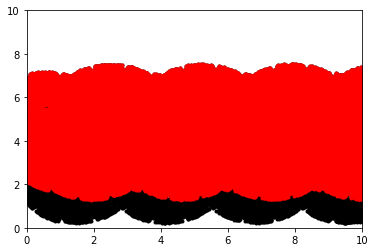

In [63]:
plt.plot(zj['RA'],zj['DEC'],'k.')
plt.plot(zj0['RA'],zj0['DEC'],'r.')
plt.xlim(0,10)
plt.ylim(0,10)

In [58]:
len(zj)




192487

In [59]:
f0 = fitsio.read('/global/cscratch1/sd/ajross/testledgers/zcat0.fits')
zj0 = join(f0,t0,keys=['TARGETID'])

In [39]:
#targets : astropy Table of targets
#truth : astropy Table of input truth with columns TARGETID, TRUEZ, and TRUETYPE

INFO:quickcat.py:592:quickcat: Mon Feb 22 13:27:53 2021 QC Reading 39 tiles
INFO:quickcat.py:636:quickcat: Mon Feb 22 13:27:55 2021 QC Trimming truth to just observed targets
INFO:quickcat.py:643:quickcat: Mon Feb 22 13:27:55 2021 QC Constructing new redshift catalog
INFO:quickcat.py:655:quickcat: Mon Feb 22 13:27:56 2021 QC Adding ZERR and ZWARN
INFO:quickcat.py:673:quickcat: Mon Feb 22 13:27:56 2021 QC Adding NUMOBS column
INFO:quickcat.py:679:quickcat: Mon Feb 22 13:27:56 2021 QC Merging previous zcat
INFO:quickcat.py:726:quickcat: Mon Feb 22 13:27:56 2021 QC done


In [43]:
desitarget.mtl.update_ledger(ldir, tars, zcat)

INFO:mtl.py:230:make_mtl: 162712 of 678179 targets have priority zero, setting N_obs=0.
INFO:mtl.py:293:make_mtl: Done...t=2.4s


In [62]:
f.readline()

'#   OBSCON: DARK, SURVEY: main}\n'

In [63]:
f = open(os.environ['CSCRATCH']+'/testledgers/dr9/0.50.0.dev4501/mtl/main/dark/mtl-dark-hp-3151.ecsv')
keyword = 'OBSCON'
for line in f:
    if keyword in line and 'name' not in line:
        break
ls = line.split(',')
for ii in range(0,len(ls)):
    if keyword in ls[ii]:
        keyval = ls[ii].split(':')[1].split("}")[0]
print(keyval)


 DARK


In [10]:
desitarget.io.read_targets_header(ldir)

INFO:io.py:3282:read_targets_header: no FITS files in /global/cscratch1/sd/ajross/testledgers/dr9/0.50.0.dev4501/mtl/main/dark/?!


OSError: FITSIO status = 108: error reading from FITS file
Error reading data buffer from file:
/global/cscratch1/sd/ajross/testledgers/dr9/0.50.0.dev4501/mtl/main/dark/
ffopen could not interpret primary array header of file: 
/global/cscratch1/sd/ajross/testledgers/dr9/0.50.0.dev4501/mtl/main/dark/


In [11]:
desitarget.io.hpdirname

AttributeError: module 'desitarget.io' has no attribute 'hpdirname'